In [81]:
import sys
sys.path.append('../..')
import torchvision 
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch as ch
import torch.nn as nn
from torch import Tensor
from torch.distributions import Gumbel
import math

import matplotlib.pyplot as plt
import cox
from cox.utils import Parameters
import cox.store as store
from cox.readers import CollectionReader
import seaborn as sns
import os
import config

from delphi import train
from delphi.cifar_models import vgg11
from delphi.utils import model_utils
from delphi import grad
from delphi import oracle
from delphi.utils.datasets import CIFAR
import delphi.utils.data_augmentation as da
import delphi.utils.constants as consts
import delphi.utils.data_augmentation as da
from delphi.utils.helpers import setup_store_with_metadata
import pickle
import pandas as pd

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

# noise distributions
gumbel = Gumbel(0, 1)

# file path constants
BASE_CLASSIFIER = '/home/pstefanou/cifar-10/resnet-18/base_classifier'
BASE_CLASSIFIER_PATH = BASE_CLASSIFIER + '/2cc80c46-2f85-4a7c-a6e1-829673d8222a/checkpoint.pt.latest'
LOGIT_BALL_CLASSIFIER = '/home/pstefanou/cifar-10/resnet-18/logit_ball_complement_logit_11'
STANDARD_CLASSIFIER = '/home/pstefanou/cifar-10/resnet-18/standard_logit_ball_complement_logit_11'
DATA_PATH = '/home/pstefanou/data/'

# helper dataset
class TruncatedCIFAR(Dataset):
    """
    Truncated CIFAR-10 dataset [Kri09]_.
    Original dataset has 50k training images and 10k testing images, with the
    following classes:
    * Airplane
    * Automobile
    * Bird
    * Cat
    * Deer
    * Dog
    * Frog
    * Horse
    * Ship
    * Truck
    .. [Kri09] Krizhevsky, A (2009). Learning Multiple Layers of Features
        from Tiny Images. Technical Report.
        
    Truncated dataset only includes images and labels from original dataset that fall within the truncation set.
    """
    def __init__(self, img, label, transform = None):
        """
        """
        self.img = img 
        self.label = label
        self.transform = transform

    def __getitem__(self, idx):
        """
        """
        x = self.img[idx]
        y = self.label[idx]
        # data augmentation
        if self.transform: 
            x = self.transform(x)
            
        return x, y
    
    def __len__(self): 
        return self.img.size(0)

# Experiment Hyperparameters

In [106]:
args = Parameters({ 
    'epochs': 150,
    'workers': 8, 
    'batch_size': 128, 
    'lr': 1e-1, 
    'accuracy': True,
    'momentum': 0.0, 
    'weight_decay': 0.0, 
    'save_ckpt_iters': 50,
    'should_save_ckpt': True,
    'log_iters': 1,
    'custom_lr_multiplier': consts.COSINE, 
    'validation_split': .8,
    'shuffle': True,
    'parallel': False, 
    'num_samples': 1000,
    'logit_ball': 11.0,
    'trials': 5,
})


if ch.cuda.is_available(): 
    args.__setattr__('device', 'cuda')
print("args: ", args)

args:  {
  "epochs": 150,
  "workers": 8,
  "batch_size": 128,
  "lr": 0.1,
  "accuracy": true,
  "momentum": 0.0,
  "weight_decay": 0.0,
  "save_ckpt_iters": 50,
  "should_save_ckpt": true,
  "log_iters": 1,
  "custom_lr_multiplier": "cosine",
  "validation_split": 0.8,
  "shuffle": true,
  "parallel": false,
  "num_samples": 1000,
  "logit_ball": 11.0,
  "trials": 5,
  "device": "cuda"
}


# Setup and Explore Dataset

In [83]:
ds = CIFAR(data_path='/home/pstefanou/')
train_loader, val_loader = ds.make_loaders(batch_size=128, workers=8, data_aug=False)

Files already downloaded and verified
Files already downloaded and verified


label: automobile


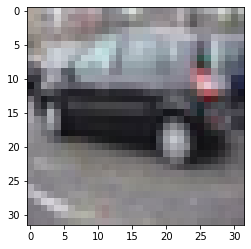

label: truck


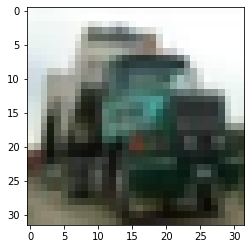

label: horse


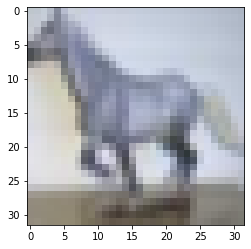

label: bird


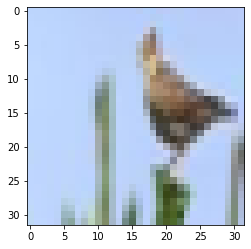

label: airplane


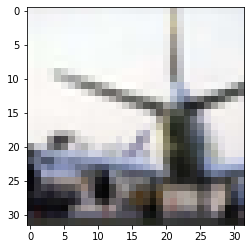

label: ship


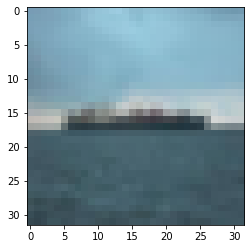

label: frog


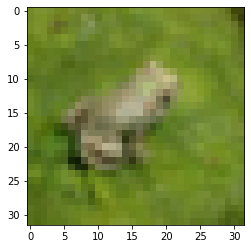

label: cat


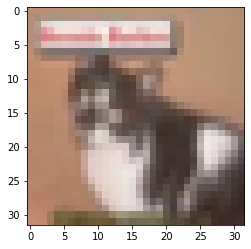

label: dog


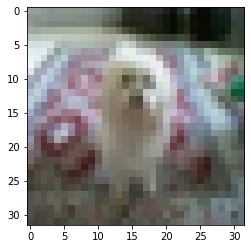

label: deer


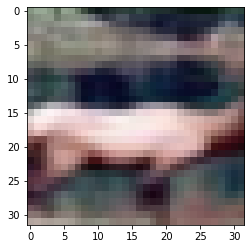

In [7]:
labels = {i for i in range(10)}
for image, target in train_loader: 
    for j in range(len(target)): 
        im, targ = image[j], target[j]
        if targ.item() in labels: 
            print("label: {}".format(da.CIFAR_LABELS[targ.item()]))
            plt.imshow(transforms.ToPILImage(mode="RGB")(im.squeeze(0)))
            plt.show()
            labels.remove(targ.item())
        if len(labels) == 0: 
            break

# Train Base Classifier

In [84]:
base_classifier, base_sd = model_utils.make_and_restore_model(arch='resnet18', dataset=ds)
out_store = store.Store(BASE_CLASSIFIER)

Logging in: /home/pstefanou/cifar-10/resnet-18/base_classifier/0b1826df-380c-435f-86ce-86f6b0277b55


In [85]:
# train
ch.manual_seed(0)
train.train_model(args, base_classifier, (train_loader, val_loader), store=out_store, parallel=args.parallel)
out_store.close()

  0%|          | 0/391 [00:00<?, ?it/s]

Exception in thread Thread-30:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/pstefanou/.local/lib/python3.6/site-packages/torch/utils/data/_utils/pin_memory.py", line 25, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/home/pstefanou/.local/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 282, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey

KeyboardInterrupt: 

In [14]:
reader = CollectionReader(BASE_CLASSIFIER)
logs = reader.df('logs')
reader.close()
logs.head()

100%|██████████| 1/1 [00:00<00:00, 100.24it/s]


,epoch,val_prec1,val_loss,train_prec1,train_loss,time,exp_id
0,1,42.110001,1.592982,31.546000,1.958489,25.509321,2cc80c46-2f85-4a7c-a6e1-829673d8222a
1,2,55.500000,1.247778,49.340000,1.386086,50.864166,2cc80c46-2f85-4a7c-a6e1-829673d8222a
2,3,56.329998,1.228012,60.354000,1.105677,76.463300,2cc80c46-2f85-4a7c-a6e1-829673d8222a
3,4,69.049995,0.872356,67.701996,0.905700,101.955784,2cc80c46-2f85-4a7c-a6e1-829673d8222a
4,5,71.309998,0.816460,72.973999,0.765090,127.400151,2cc80c46-2f85-4a7c-a6e1-829673d8222a


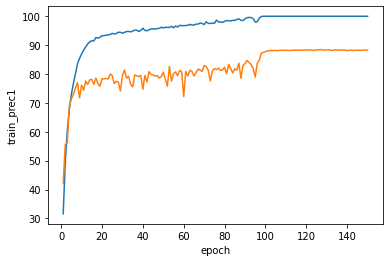

<AxesSubplot:xlabel='epoch', ylabel='train_loss'>

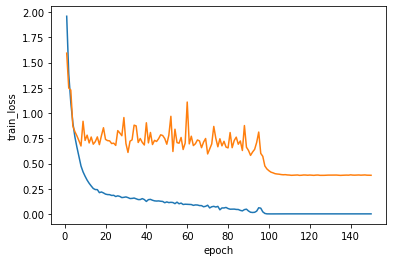

In [15]:
sns.lineplot(data=logs, x='epoch', y='train_prec1')
sns.lineplot(data=logs, x='epoch', y='val_prec1')
plt.show()
sns.lineplot(data=logs, x='epoch', y='train_loss')
sns.lineplot(data=logs, x='epoch', y='val_loss')

# Truncate CIFAR-10

In [86]:
base_classifier = model_utils.make_and_restore_model(arch='resnet18', dataset=ds, resume_path=BASE_CLASSIFIER_PATH)[0]

=> loading checkpoint '/home/pstefanou/cifar-10/resnet-18/base_classifier/2cc80c46-2f85-4a7c-a6e1-829673d8222a/checkpoint.pt.latest'
=> loaded checkpoint '/home/pstefanou/cifar-10/resnet-18/base_classifier/2cc80c46-2f85-4a7c-a6e1-829673d8222a/checkpoint.pt.latest' (epoch 150)


In [27]:
# membership oracle
phi = oracle.LogitBallComplement(args.logit_ball)

# check if there exists a cifar 10 train truncated dataset already
if not os.path.isfile(DATA_PATH + 'trunc_train_logit_' + str(args.logit_ball) + '.pickle') or not os.path.isfile(DATA_PATH + 'trunc_test_logit_' + str(args.logit_ball) + '.pickle'):
    trunc_train_X, trunc_train_y = Tensor([]), Tensor([])
    # unseen test data
    trunc_test_X, trunc_test_y = Tensor([]), Tensor([])
    for inp, targ in train_loader: 
        inp, targ = inp.to(args.device), targ.to(args.device)
        logits, inp = base_classifier(inp)
        # add gumbel noise to the logits
        noised = logits.cpu() + gumbel.sample(logits.size())
        filtered = phi(noised)
        indices = filtered.nonzero(as_tuple=False).flatten()
        test_indices = (~filtered).nonzero(as_tuple=False).flatten()
        trunc_train_X, trunc_train_y = ch.cat([trunc_train_X, inp[indices].cpu()]), ch.cat([trunc_train_y, targ[indices].cpu()])
        trunc_test_X, trunc_test_y = ch.cat([trunc_test_X, inp[test_indices].cpu()]), ch.cat([trunc_test_y, targ[test_indices].cpu()])

    print("train alpha: ", trunc_train_X.size(0) / len(train_loader.dataset))
    trunc_train_loader = DataLoader(TruncatedCIFAR(trunc_train_X, trunc_train_y.long(), transform= None), num_workers=args.workers, shuffle=args.shuffle, batch_size=args.batch_size)

    # train loader
    with open(DATA_PATH + 'trunc_train_logit_' + str(args.logit_ball) + '.pickle', 'wb') as f: 
        pickle.dump(trunc_train_loader, f)
else:  
    trunc_train_loader = pd.read_pickle(DATA_PATH + 'trunc_train_logit_' + str(args.logit_ball) + '.pickle')
trunc_train_loader

train alpha:  0.13676


In [28]:
# check if there exists a cifar 10 valdation and test truncated dataset
if not os.path.isfile(DATA_PATH + 'trunc_val_logit_' + str(args.logit_ball) + '.pickle') or not os.path.isfile(DATA_PATH + 'trunc_test_logit_' + str(args.logit_ball) + '.pickle'):
    trunc_val_X, trunc_val_y = Tensor([]), Tensor([]) 

    for inp, targ in val_loader: 
        inp, targ = inp.to(args.device), targ.to(args.device)
        logits, inp = base_classifier(inp)
        # add gumbel noise to the logits
        noised = logits.cpu() + gumbel.sample(logits.size())
        filtered = phi(noised)
        indices = filtered.nonzero(as_tuple=False).flatten()
        test_indices = (~filtered).nonzero(as_tuple=False).flatten()
        trunc_val_X, trunc_val_y = ch.cat([trunc_val_X, inp[indices].cpu()]), ch.cat([trunc_val_y, targ[indices].cpu()])
        trunc_test_X, trunc_test_y = ch.cat([trunc_test_X, inp[test_indices].cpu()]), ch.cat([trunc_test_y, targ[test_indices].cpu()])

    print("val alpha: ", trunc_val_X.size(0) / len(val_loader.dataset))
    trunc_val_loader = DataLoader(TruncatedCIFAR(trunc_val_X, trunc_val_y.long(), transform=None), num_workers=args.workers, shuffle=args.shuffle, batch_size=args.batch_size)
    # truncated test set (unseen data that the model has not been tested on)
    trunc_test_loader = DataLoader(TruncatedCIFAR(trunc_test_X, trunc_test_y.long(), transform=None), 
                             num_workers=args.workers, shuffle=args.shuffle, batch_size=args.batch_size)

    # validation loader
    with open(DATA_PATH + 'trunc_val_logit_' + str(args.logit_ball) + '.pickle', 'wb') as f: 
        pickle.dump(trunc_val_loader, f)

    # test loader
    with open(DATA_PATH + 'trunc_test_logit_' + str(args.logit_ball) + '.pickle', 'wb') as f: 
        pickle.dump(trunc_test_loader, f)
else: 
    trunc_val_loader = pd.read_pickle(DATA_PATH + 'trunc_val_logit_'+ str(args.logit_ball) + '.pickle')
    trunc_test_loader = pd.read_pickle(DATA_PATH + 'trunc_test_logit_' + str(args.logit_ball) + '.pickle')
trunc_val_loader, trunc_test_loader

val alpha:  0.1671


(<torch.utils.data.dataloader.DataLoader at 0x7f8ecdbe4588>,
 <torch.utils.data.dataloader.DataLoader at 0x7f8ecdbe4898>)

In [80]:
print("alpha train: ", len(trunc_train_loader.dataset) / len(train_loader.dataset))
print("alpha val: ", len(trunc_val_loader.dataset) / len(val_loader.dataset))
print("test set size: ", len(trunc_test_loader.dataset))

alpha train:  0.13676
alpha val:  0.1671
test set size:  51491


# Setup Store and Train Model

In [112]:
standard_model, _ = model_utils.make_and_restore_model(arch='resnet18', dataset=ds)
# logging store
out_store = store.Store(STANDARD_CLASSIFIER)
setup_store_with_metadata(args, out_store)
args.__setattr__('custom_criterion', None)

Logging in: /home/pstefanou/cifar-10/resnet-18/standard_logit_ball_complement_logit_11/ad34b82e-07dc-4633-ac46-0dabd11e5200


# Start by Training Standard Classifier

In [113]:
# train
ch.manual_seed(0)
args.__setattr__('epochs', 2)
standard_model = train.train_model(args, standard_model, (trunc_train_loader, trunc_val_loader), store=out_store, parallel=args.parallel)

# evaluate model on train, validation, and unseen datasets
test_set_results = train.eval_model(args, standard_model, trunc_test_loader, out_store)
print("test set results: ", test_set_results)
train_set_results = train.eval_model(args, standard_model, trunc_train_loader, out_store)
print("train set results: ", train_set_results)
val_set_results = train.eval_model(args, standard_model, trunc_val_loader, out_store) 
print("val set results: ", val_set_results)

out_store.close()

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/403 [00:00<?, ?it/s]

test set results:  {'test_prec1': tensor(30.9491, device='cuda:0'), 'test_loss': 1.9285789493663323, 'time': 8.043207168579102}


  0%|          | 0/54 [00:00<?, ?it/s]

train set results:  {'test_prec1': tensor(33.5186, device='cuda:0'), 'test_loss': 1.8142407491005592, 'time': 1.6352791786193848}


  0%|          | 0/14 [00:00<?, ?it/s]

val set results:  {'test_prec1': tensor(36.7445, device='cuda:0'), 'test_loss': 1.7089351550466925, 'time': 0.9376804828643799}


In [110]:
reader = CollectionReader(STANDARD_CLASSIFIER)
metadata = reader.df('metadata')
logs = reader.df('logs')
reader.close()
logs.head()

 80%|████████  | 4/5 [00:00<00:00, 73.61it/s]


ValueError: The file '/home/pstefanou/cifar-10/resnet-18/standard_logit_ball_complement_logit_11/178d34dc-9085-4227-a506-882f87629e6f/store.h5' is already opened, but not in read-only mode (as requested).

# Plot Standard Trained Classifier Loss and Accuracy Curves

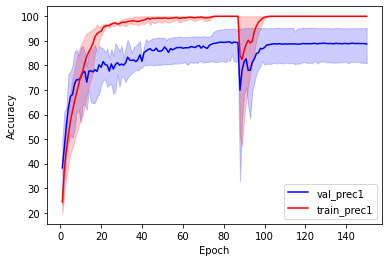

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss')]

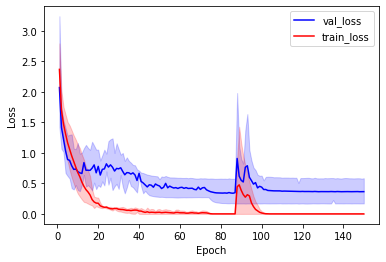

In [33]:
sns.lineplot(data=logs, x='epoch', y='val_prec1', label='val_prec1', color='b')
ax = sns.lineplot(data=logs, x='epoch', y='train_prec1', label='train_prec1', color='r')
ax.set(xlabel='Epoch', ylabel='Accuracy')
plt.show()

sns.lineplot(data=logs, x='epoch', y='val_loss', label='val_loss', color='b')
ax = sns.lineplot(data=logs, x='epoch', y='train_loss', label='train_loss', color='r')
ax.set(xlabel='Epoch', ylabel='Loss')

In [135]:
##### logging store
out_store = store.Store(LOGIT_BALL_CLASSIFIER)
setup_store_with_metadata(args, out_store)
# load in previously trained classifer to run truncated gradient against it
delphi_ =  model_utils.make_and_restore_model(arch='resnet18', dataset=ds, resume_path=STANDARD_CLASSIFIER + '/ad34b82e-07dc-4633-ac46-0dabd11e5200/checkpoint.pt.latest')
# set oracle
args.__setattr__('phi', phi)
# set gradient 
args.__setattr__('custom_criterion', grad.TruncatedCE.apply)
# decrease learning rate
args.__setattr__('lr', 1e-2)

Logging in: /home/pstefanou/cifar-10/resnet-18/logit_ball_complement_logit_11/5041eb67-2d05-4b61-9592-ba6fc4c48162
=> loading checkpoint '/home/pstefanou/cifar-10/resnet-18/standard_logit_ball_complement_logit_11/ad34b82e-07dc-4633-ac46-0dabd11e5200/checkpoint.pt.latest'
=> loaded checkpoint '/home/pstefanou/cifar-10/resnet-18/standard_logit_ball_complement_logit_11/ad34b82e-07dc-4633-ac46-0dabd11e5200/checkpoint.pt.latest' (epoch 2)


Sanity check to make sure that we loader in the correct model

In [136]:
train.eval_model(args, delphi_[0], trunc_test_loader, out_store)

  0%|          | 0/403 [00:00<?, ?it/s]

{'test_prec1': tensor(30.9491, device='cuda:0'),
 'test_loss': 1.928578950500755,
 'time': 8.435184717178345}

# TruncatedCE with Logit Ball Oracle

In [ ]:
# train
ch.manual_seed(0)
args.__setattr__('epochs', 200)
config.args = args
final_model = train.train_model(args, delphi_[0], (trunc_train_loader, trunc_val_loader), store=out_store, parallel=args.parallel)
out_store.close()

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

In [121]:
reader = CollectionReader(LOGIT_BALL_CLASSIFIER)
metadata = reader.df('metadata')
trunc_logs = reader.df('logs')
reader.close()
trunc_logs

  0%|          | 0/5 [00:00<?, ?it/s]


ValueError: The file '/home/pstefanou/cifar-10/resnet-18/logit_ball_complement_logit_11/fa05bbbf-2a97-465c-8698-3e3e31dafc75/store.h5' is already opened, but not in read-only mode (as requested).

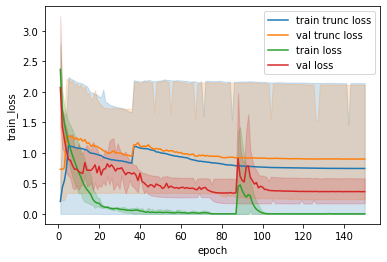

<AxesSubplot:xlabel='epoch', ylabel='train_prec1'>

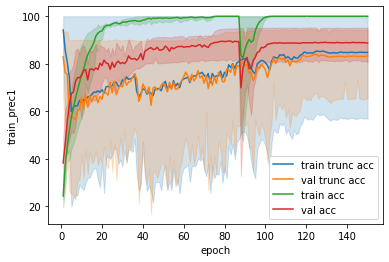

In [39]:
sns.lineplot(data=trunc_logs, x='epoch', y='train_loss', label='train trunc loss')
sns.lineplot(data=trunc_logs, x='epoch', y='val_loss', label='val trunc loss')

sns.lineplot(data=logs, x='epoch', y='train_loss', label='train loss')
sns.lineplot(data=logs, x='epoch', y='val_loss', label='val loss')
plt.show()

sns.lineplot(data=trunc_logs, x='epoch', y='train_prec1', label='train trunc acc')
sns.lineplot(data=trunc_logs, x='epoch', y='val_prec1', label='val trunc acc')

sns.lineplot(data=logs, x='epoch', y='train_prec1', label='train acc')
sns.lineplot(data=logs, x='epoch', y='val_prec1', label='val acc')

# Load Trained Models into Notebook

In [122]:
base = model_utils.make_and_restore_model(arch='resnet18', dataset=ds, resume_path=BASE_CLASSIFIER_PATH)
delphi_ = model_utils.make_and_restore_model(arch='resnet18', dataset=ds, resume_path=LOGIT_BALL_CLASSIFIER + '/26b37487-0c65-43a3-a3b0-524e9130695d/checkpoint.pt.latest')
standard_model =  model_utils.make_and_restore_model(arch='resnet18', dataset=ds, resume_path=STANDARD_CLASSIFIER + '/ad34b82e-07dc-4633-ac46-0dabd11e5200/checkpoint.pt.latest')

=> loading checkpoint '/home/pstefanou/cifar-10/resnet-18/base_classifier/2cc80c46-2f85-4a7c-a6e1-829673d8222a/checkpoint.pt.latest'
=> loaded checkpoint '/home/pstefanou/cifar-10/resnet-18/base_classifier/2cc80c46-2f85-4a7c-a6e1-829673d8222a/checkpoint.pt.latest' (epoch 150)
=> loading checkpoint '/home/pstefanou/cifar-10/resnet-18/logit_ball_complement_logit_11/26b37487-0c65-43a3-a3b0-524e9130695d/checkpoint.pt.latest'
=> loaded checkpoint '/home/pstefanou/cifar-10/resnet-18/logit_ball_complement_logit_11/26b37487-0c65-43a3-a3b0-524e9130695d/checkpoint.pt.latest' (epoch 50)
=> loading checkpoint '/home/pstefanou/cifar-10/resnet-18/standard_logit_ball_complement_logit_11/ad34b82e-07dc-4633-ac46-0dabd11e5200/checkpoint.pt.latest'
=> loaded checkpoint '/home/pstefanou/cifar-10/resnet-18/standard_logit_ball_complement_logit_11/ad34b82e-07dc-4633-ac46-0dabd11e5200/checkpoint.pt.latest' (epoch 2)


# Test Accuracy

In [123]:
delphi_store = store.Store(LOGIT_BALL_CLASSIFIER)

Logging in: /home/pstefanou/cifar-10/resnet-18/logit_ball_complement_logit_11/16da7d29-1c33-4d13-906e-8a9ee2689b56


In [124]:
delphi_test_results = train.eval_model(args, delphi_[0], trunc_test_loader, delphi_store)
print("delphi test results: ", delphi_test_results)

delphi_train_results = train.eval_model(args, delphi_[0], trunc_train_loader, delphi_store)
print("delphi train results: ", delphi_train_results)

delphi_val_results = train.eval_model(args, delphi_[0], trunc_val_loader, delphi_store)
print("delphi val results: ", delphi_val_results)
delphi_store.close()

  0%|          | 0/403 [00:00<?, ?it/s]

delphi test results:  {'test_prec1': tensor(33.2835, device='cuda:0'), 'test_loss': 2.1809380147450224, 'time': 8.02819561958313}


  0%|          | 0/54 [00:00<?, ?it/s]

delphi train results:  {'test_prec1': tensor(39.7631, device='cuda:0'), 'test_loss': 2.152487570934736, 'time': 1.64158296585083}


  0%|          | 0/14 [00:00<?, ?it/s]

delphi val results:  {'test_prec1': tensor(43.0281, device='cuda:0'), 'test_loss': 2.1385707117568082, 'time': 0.907672643661499}


In [125]:
base_store = store.Store(BASE_CLASSIFIER)

Logging in: /home/pstefanou/cifar-10/resnet-18/base_classifier/59c267f8-b9e5-47df-a6ff-37e538ba5156


In [126]:
base_test_results = train.eval_model(args, base_classifier, trunc_test_loader, base_store)
print("base test results: ", base_test_results)

base_train_results = train.eval_model(args, base_classifier, trunc_train_loader, base_store)
print("base train results: ", base_train_results)

base_val_results = train.eval_model(args, base_classifier, trunc_val_loader, base_store)
print("base val results: ", base_val_results)
base_store.close()

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8e3f2908d0>>
Traceback (most recent call last):
  File "/home/pstefanou/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/pstefanou/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1291, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


  0%|          | 0/403 [00:00<?, ?it/s]

base test results:  {'test_prec1': tensor(97.7724, device='cuda:0'), 'test_loss': 0.07329571592926074, 'time': 8.396729230880737}


  0%|          | 0/54 [00:00<?, ?it/s]

base train results:  {'test_prec1': tensor(100., device='cuda:0'), 'test_loss': 0.0011459382939863101, 'time': 1.58433198928833}


  0%|          | 0/14 [00:00<?, ?it/s]

base val results:  {'test_prec1': tensor(98.5039, device='cuda:0'), 'test_loss': 0.07286604130729105, 'time': 0.8377108573913574}


In [127]:
standard_store = store.Store(STANDARD_CLASSIFIER)

Logging in: /home/pstefanou/cifar-10/resnet-18/standard_logit_ball_complement_logit_11/4ebc15d7-69bb-4ffe-843b-6acd44e6d4b0


In [128]:
standard_test_results = train.eval_model(args, standard_model[0], trunc_test_loader, standard_store)
print("standard test results: ", standard_test_results)

standard_train_results = train.eval_model(args, standard_model[0], trunc_train_loader, standard_store)
print("standard train results: ", standard_train_results)

standard_val_results = train.eval_model(args, standard_model[0], trunc_val_loader, standard_store)
print("standard val results: ", standard_val_results)
standard_store.close()

  0%|          | 0/403 [00:00<?, ?it/s]

standard test results:  {'test_prec1': tensor(30.9491, device='cuda:0'), 'test_loss': 1.928578956492358, 'time': 8.174416780471802}


  0%|          | 0/54 [00:00<?, ?it/s]

standard train results:  {'test_prec1': tensor(33.5186, device='cuda:0'), 'test_loss': 1.814240824063991, 'time': 1.6053500175476074}


  0%|          | 0/14 [00:00<?, ?it/s]

standard val results:  {'test_prec1': tensor(36.7445, device='cuda:0'), 'test_loss': 1.708935115738303, 'time': 0.8833568096160889}
